In [1]:
# ECG Heartbeat Categorization

import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Path to dataset files: /Volumes/HP_P900/Users/tungnguyen/.cache/kagglehub/datasets/shayanfazeli/heartbeat/versions/1


In [2]:
import os 
os.listdir(path)

['mitbih_test.csv',
 'ptbdb_abnormal.csv',
 'ptbdb_normal.csv',
 'mitbih_train.csv']

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import models, layers

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from model import ECGNet, train_model, evaluate_model, plot_training_history

import os
cwd = os.getcwd()
os.makedirs(os.path.join(cwd, "fig"), exist_ok=True)

train_df = pd.read_csv(os.path.join(path, 'mitbih_train.csv'), header=None)
test_df = pd.read_csv(os.path.join(path, 'mitbih_test.csv'), header=None)

Using device: mps


## Dataset overview

In [4]:
train_df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.423611,0.791667,1.000000,0.256944,0.000000,0.277778,0.465278,0.520833,0.472222,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.716814,0.539823,0.283186,0.129794,0.064897,0.076696,0.026549,0.032448,0.008850,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.874214,0.849057,0.480084,0.058700,0.090147,0.310273,0.387841,0.385744,0.389937,0.392034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.996086,0.694716,0.336595,0.238748,0.268102,0.191781,0.174168,0.164384,0.187867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print(train_df.shape)
y_train = train_df[187]
print(y_train.shape)
X_train = train_df.iloc[:, :187]
print(X_train.shape)

print(test_df.shape)
y_test = test_df[187]
print(y_test.shape)
X_test = test_df.iloc[:, :187]
print(X_test.shape)


(87554, 188)
(87554,)
(87554, 187)
(21892, 188)
(21892,)
(21892, 187)


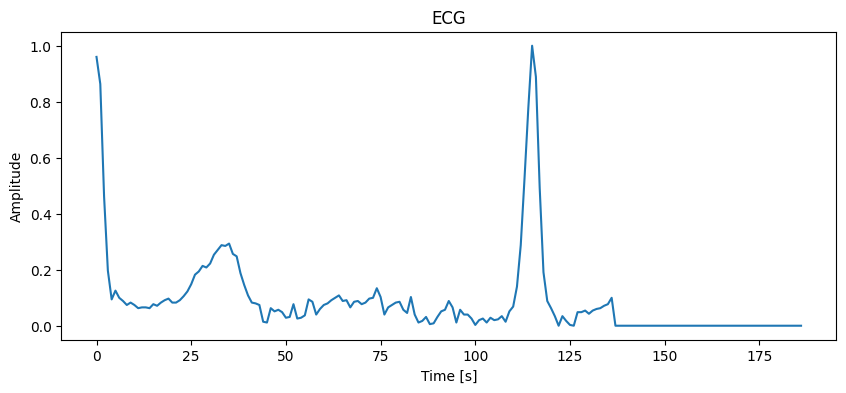

In [6]:
# 1: N, 2: S, 3: V, 4: F, 5: Q

def plot_ecg(ecg, title="ECG"):
    plt.figure(figsize=(10, 4))
    plt.plot(ecg)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.savefig("fig/ecg.svg", format="svg")
    plt.show()

plot_ecg(X_train.iloc[1])

In [7]:
y_train.value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

/var/folders/wj/8406k4zs34b1rtmbdltdknl00000gp/T/ipykernel_30741/1831208905.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=list(colors))


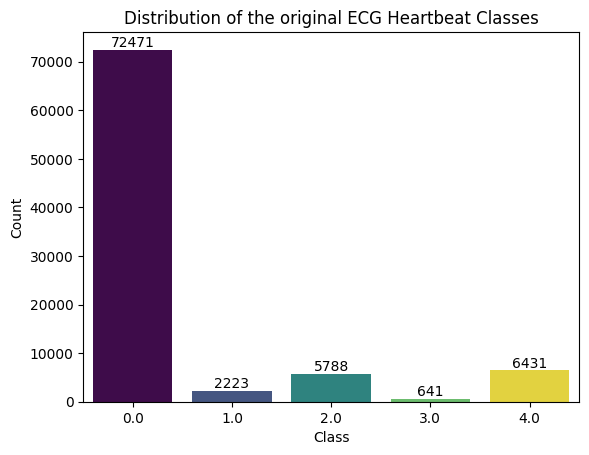

In [8]:
def plot_distribution(y_train, image_name="distribution.svg", title="Distribution of ECG Heartbeat Classes"):
    value_counts = y_train.value_counts().sort_index()

    colors = cm.viridis(np.linspace(0, 1, len(value_counts)))
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=list(colors))

    for i, v in enumerate(value_counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom')

    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig(image_name, format="svg")
    plt.show()

plot_distribution(y_train, "fig/original_distribution.svg", "Distribution of the original ECG Heartbeat Classes")

## Process dataset

### Downsample class 0, Upsample other class

In [9]:
print("Original distribution:")
print(y_train.value_counts().sort_index())


Original distribution:
187
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64


187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: count, dtype: int64


/var/folders/wj/8406k4zs34b1rtmbdltdknl00000gp/T/ipykernel_30741/1831208905.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=list(colors))


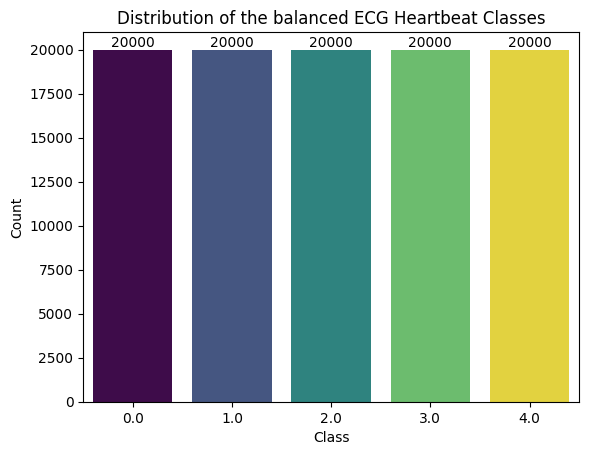

In [10]:
oversample = SMOTE(sampling_strategy={1: 20000, 2: 20000, 3: 20000, 4: 20000}, 
                   random_state=42)

undersample = RandomUnderSampler(sampling_strategy={0: 20000}, random_state=42)

pipeline = Pipeline([('over', oversample), ('under', undersample)])

X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

print(pd.Series(y_train_balanced).value_counts().sort_index())

plot_distribution(y_train_balanced, "fig/balanced_distribution.svg", "Distribution of the balanced ECG Heartbeat Classes")

## Random Forest


In [11]:
def plot_full_and_normalized_cm(y_true, y_pred, image_name="fig/confusion_matrix.svg", title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    disp_full = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp_full.plot(ax=axes[0], colorbar=False)
    axes[0].set_title("Confusion Matrix (Counts)")

    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
    disp_norm.plot(ax=axes[1], colorbar=False, values_format='.2f')
    axes[1].set_title("Confusion Matrix (Normalized)")

    plt.tight_layout()
    plt.savefig(image_name, format="svg")
    plt.show()


### No resample

0.9743285218344601
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18118
         1.0       0.98      0.60      0.75       556
         2.0       0.98      0.88      0.93      1448
         3.0       0.89      0.62      0.73       162
         4.0       0.99      0.94      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.96      0.81      0.87     21892
weighted avg       0.97      0.97      0.97     21892



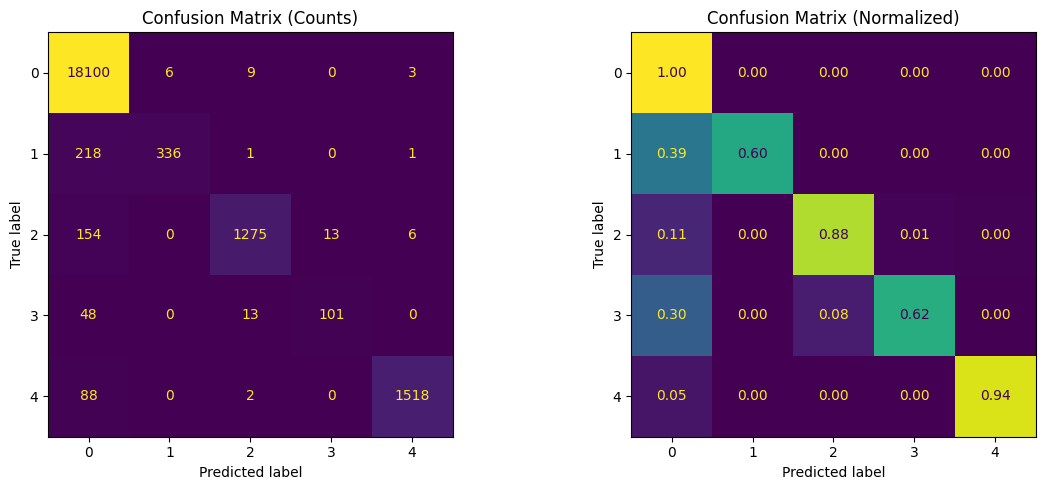

In [12]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

plot_full_and_normalized_cm(y_test, y_pred, "fig/rf_original_confusion_matrix.svg")

In [13]:
del rf, y_pred

### With resample

0.9735976612461174
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     18118
         1.0       0.72      0.80      0.76       556
         2.0       0.93      0.94      0.94      1448
         3.0       0.69      0.81      0.74       162
         4.0       0.98      0.97      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.86      0.90      0.88     21892
weighted avg       0.97      0.97      0.97     21892



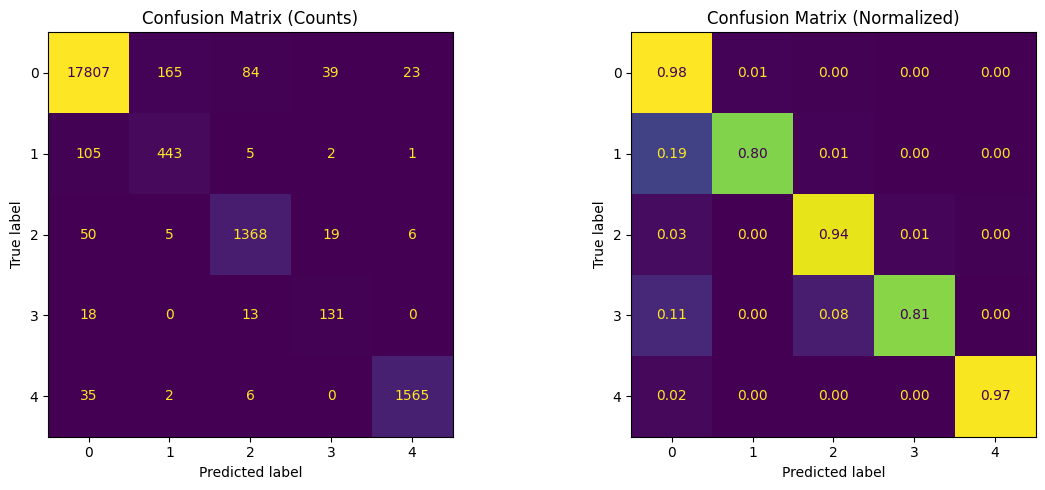

In [14]:
rf_balanc = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_balanc.fit(X_train_balanced, y_train_balanced)

y_pred_balanced = rf_balanc.predict(X_test)

print(accuracy_score(y_test, y_pred_balanced))

print(classification_report(y_test, y_pred_balanced))

plot_full_and_normalized_cm(y_test, y_pred_balanced, "fig/rf_balanced_confusion_matrix.svg")

## CNN model

In [15]:
device = "mps"

### CNN without resample

ECGNet(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2752, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Train Loss: 0.2662, Train Acc: 92.54%, Val Loss: 0.1472, Val Acc: 95.63%
Epoch [2/10], Train Loss: 0.1540, Train Acc: 95.87%, Val Loss: 0.1134, Val Acc: 96.97%
Epoch [3/10], Train Loss: 0.1281, Train Acc: 96.59%, Val Loss: 0.1013, Val Acc: 97.31%
Epoch [4/10], Train Loss: 0.1084, Train Acc: 97.04%, Val Loss: 0.0902, Val Acc: 97.63%
Epoch [5/10], Train Loss: 0.0985, Train Acc: 97.32%, Val Loss: 0.0839, Val Acc: 97.60%
Epoc

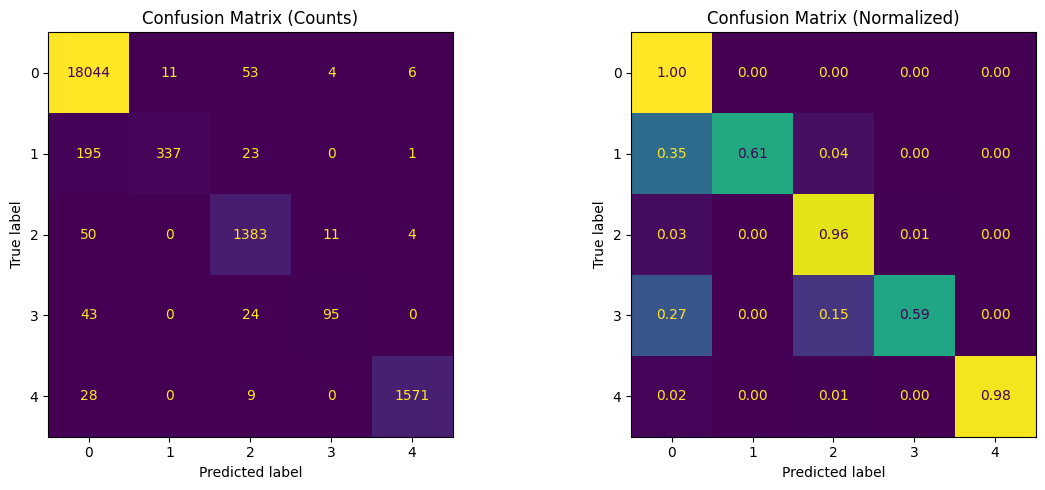

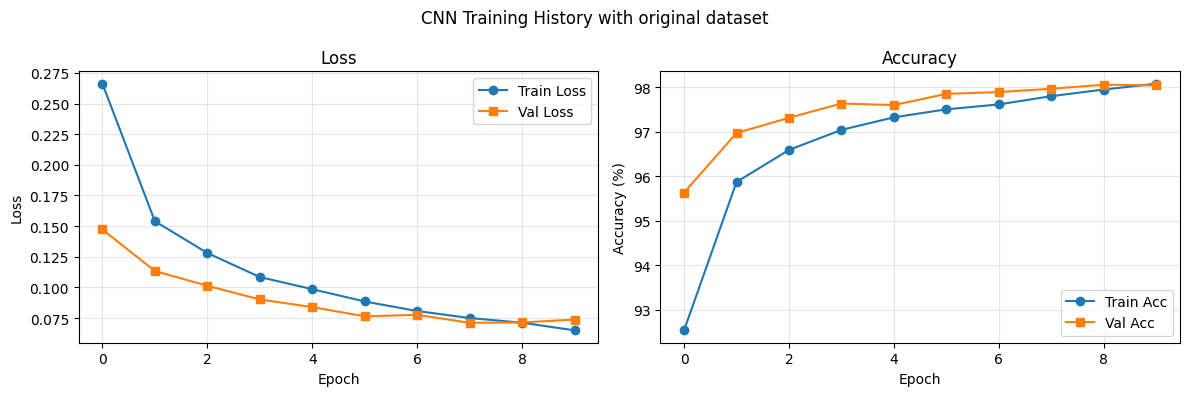

In [16]:
X_train_torch = X_train.values.reshape(-1, 1, 187).astype(np.float32)
X_test_torch = X_test.values.reshape(-1, 1, 187).astype(np.float32)
y_train_torch = y_train.values.astype(np.int64)
y_test_torch = y_test.values.astype(np.int64)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_torch, y_train_torch, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(torch.FloatTensor(X_train_split), torch.LongTensor(y_train_split))
val_dataset = TensorDataset(torch.FloatTensor(X_val_split), torch.LongTensor(y_val_split))
test_dataset = TensorDataset(torch.FloatTensor(X_test_torch), torch.LongTensor(y_test_torch))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model_original = ECGNet().to(device)
print(model_original)

history_original = train_model(model_original, train_loader, val_loader, epochs=10)

y_test_true, y_pred_cnn_orig, test_loss_orig, test_acc_orig = evaluate_model(model_original, test_loader)

print(f"Test Accuracy: {test_acc_orig}%")
print(f"Test Loss: {test_loss_orig}")

print(classification_report(y_test_true, y_pred_cnn_orig))
plot_full_and_normalized_cm(y_test_true, y_pred_cnn_orig, "fig/cnn_original_confusion_matrix.svg")

plot_training_history(history_original, 
                     title="CNN Training History with original dataset",
                     save_path="fig/cnn_original_history.svg")


### CNN with resample

Epoch [1/10], Train Loss: 0.4505, Train Acc: 83.36%, Val Loss: 0.2199, Val Acc: 91.72%
Epoch [2/10], Train Loss: 0.2350, Train Acc: 91.56%, Val Loss: 0.1446, Val Acc: 94.88%
Epoch [3/10], Train Loss: 0.1812, Train Acc: 93.62%, Val Loss: 0.1166, Val Acc: 95.93%
Epoch [4/10], Train Loss: 0.1476, Train Acc: 94.80%, Val Loss: 0.0928, Val Acc: 96.67%
Epoch [5/10], Train Loss: 0.1265, Train Acc: 95.56%, Val Loss: 0.0796, Val Acc: 97.33%
Epoch [6/10], Train Loss: 0.1101, Train Acc: 96.11%, Val Loss: 0.0697, Val Acc: 97.66%
Epoch [7/10], Train Loss: 0.1000, Train Acc: 96.57%, Val Loss: 0.0668, Val Acc: 97.80%
Epoch [8/10], Train Loss: 0.0880, Train Acc: 96.93%, Val Loss: 0.0629, Val Acc: 98.00%
Epoch [9/10], Train Loss: 0.0792, Train Acc: 97.19%, Val Loss: 0.0540, Val Acc: 98.33%
Epoch [10/10], Train Loss: 0.0743, Train Acc: 97.38%, Val Loss: 0.0537, Val Acc: 98.34%
Test Accuracy: 95.8249588890919%
Test Loss: 0.153028781867924
              precision    recall  f1-score   support

           0

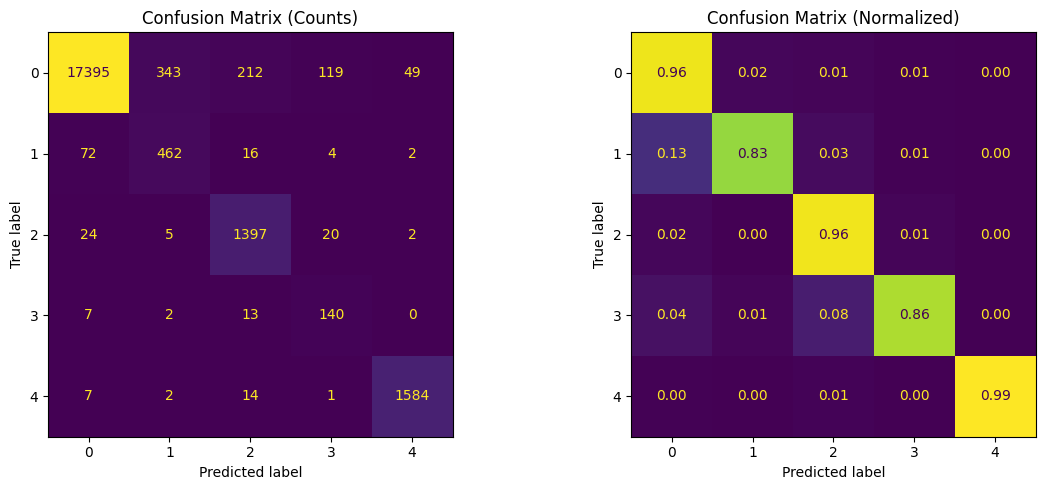

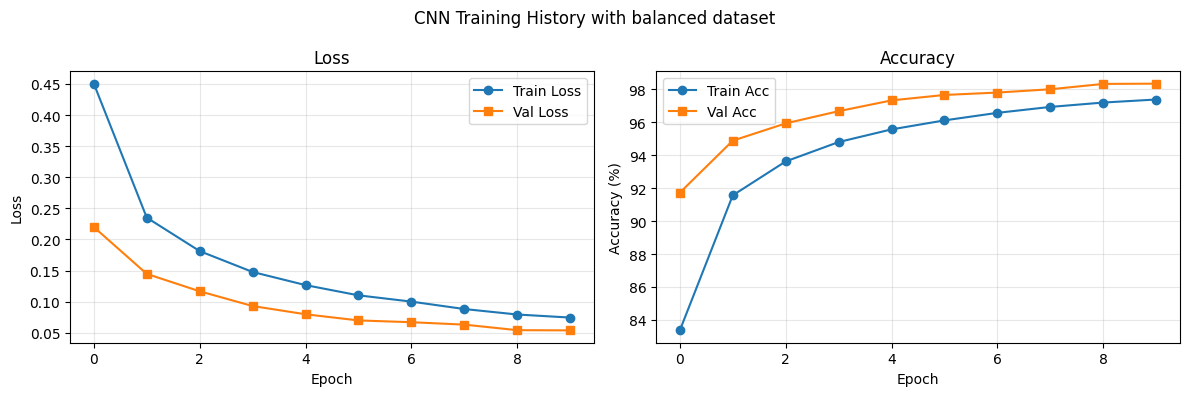

In [17]:
X_train_balanced_torch = X_train_balanced.values.reshape(-1, 1, 187).astype(np.float32)
y_train_balanced_torch = y_train_balanced.values.astype(np.int64)

X_train_bal_split, X_val_bal_split, y_train_bal_split, y_val_bal_split = train_test_split(
    X_train_balanced_torch, y_train_balanced_torch, test_size=0.2, random_state=42
)

train_bal_dataset = TensorDataset(torch.FloatTensor(X_train_bal_split), torch.LongTensor(y_train_bal_split))
val_bal_dataset = TensorDataset(torch.FloatTensor(X_val_bal_split), torch.LongTensor(y_val_bal_split))

train_bal_loader = DataLoader(train_bal_dataset, batch_size=32, shuffle=True)
val_bal_loader = DataLoader(val_bal_dataset, batch_size=32, shuffle=False)

model_balanced = ECGNet().to(device)

history_balanced = train_model(model_balanced, train_bal_loader, val_bal_loader, epochs=10)

y_test_true, y_pred_cnn_bal, test_loss_bal, test_acc_bal = evaluate_model(model_balanced, test_loader)

print(f"Test Accuracy: {test_acc_bal}%")
print(f"Test Loss: {test_loss_bal}")

print(classification_report(y_test_true, y_pred_cnn_bal))
plot_full_and_normalized_cm(y_test_true, y_pred_cnn_bal, "fig/cnn_balanced_confusion_matrix.svg")

plot_training_history(history_balanced, 
                     title="CNN Training History with balanced dataset",
                     save_path="fig/cnn_balanced_history.svg")